In [1]:
from tensorflow.keras.models import Model
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from google.cloud import bigquery
from tensorflow.keras.callbacks import ReduceLROnPlateau
import warnings
warnings.filterwarnings('ignore')

In [2]:
from tensorflow_io.bigquery import BigQueryClient
from tensorflow_io.bigquery import BigQueryReadSession
from tensorflow.python.framework import dtypes

from tensorflow import feature_column

In [3]:
from tensorflow.keras import layers, losses, optimizers

In [4]:
def features_and_labels(features):
    target = features.pop('s1')
    #enodeb = features.pop('enodeb')
    return features, target

def read_bigquery():
    batch_size=5
    tensorflow_io_bigquery_client = BigQueryClient()
    read_session = tensorflow_io_bigquery_client.read_session(
          "projects/" + PROJECT_ID,
           PROJECT_ID, TABLE_ID, DATASET_ID, COL_NAMES, COL_TYPES,
          requested_streams=2)

    dataset = read_session.parallel_read_rows()
    transformed_ds = dataset.map(features_and_labels).shuffle(batch_size*10).batch(batch_size)
    return transformed_ds

In [5]:
x = [dtypes.float64]
x*4

[tf.float64, tf.float64, tf.float64, tf.float64]

In [6]:
def create_window_list(NB_LAG):
    window_list = []
    for l in range(NB_LAG):
        if l<NB_LAG:
            window_list.append(f't_{NB_LAG-l}')
    return window_list

l = create_window_list(4)

COL_TYPES = []
for i in range(len(l)):
    x = [dtypes.float64]
    COL_TYPES = COL_TYPES + x
    
COL_NAMES = l
COL_NAMES = COL_NAMES + ['enodeb', 's1'] # s1 is the column with the labels
COL_TYPES = COL_TYPES + [dtypes.string, dtypes.float64]

print(f'COL_NAMES {COL_NAMES}')
print(f'COL_TYPES {COL_TYPES}')


COL_NAMES ['t_4', 't_3', 't_2', 't_1', 'enodeb', 's1']
COL_TYPES [tf.float64, tf.float64, tf.float64, tf.float64, tf.string, tf.float64]


This is the query I used to select the data, but it's wrong, because when you lag the column and order by the time, it's not strictly sorted because there are multiple aggregations and therefore the times are repeated.

In [7]:
PROJECT_ID='pbalm-orange'  
DATASET_ID='test' # test dataset
TABLE_ID  = 'kpi_s1_lags'

In [8]:
training_ds = read_bigquery()

2022-06-17 19:40:02.458343: W tensorflow_io/core/kernels/audio_video_mp3_kernels.cc:271] libmp3lame.so.0 or lame functions are not available
2022-06-17 19:40:02.458767: I tensorflow_io/core/kernels/cpu_check.cc:128] Your CPU supports instructions that this TensorFlow IO binary was not compiled to use: AVX2 FMA
2022-06-17 19:40:02.612414: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [9]:
training_ds

<BatchDataset element_spec=(OrderedDict([('enodeb', TensorSpec(shape=(None,), dtype=tf.string, name=None)), ('t_1', TensorSpec(shape=(None,), dtype=tf.float64, name=None)), ('t_2', TensorSpec(shape=(None,), dtype=tf.float64, name=None)), ('t_3', TensorSpec(shape=(None,), dtype=tf.float64, name=None)), ('t_4', TensorSpec(shape=(None,), dtype=tf.float64, name=None))]), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

In [10]:
window_size = 4

In [11]:
str_lookup_layer = layers.StringLookup(name='string_lookup')
str_lookup_layer.adapt(['1'])

In [12]:
def get_model(str_layer):
    # generate one input layer per feature column
    inputs = {f't_{i}': layers.Input(name=f't_{i}', shape=(1,), dtype='float64') for i in range(1, window_size+1)}
    inputs['enodeb'] = layers.Input(shape=[], dtype=tf.string, name='enodeb')
    
    sorted_keys = list(inputs.keys())
    sorted_keys.sort()
    input_list = [inputs[k] for k in sorted_keys]
    
    d = layers.concatenate([inputs[k] for k in inputs if k.startswith('t')], name='concat')
    x = layers.Dense(4, activation="relu", name='autoenc_1')(d)
    x = layers.Dense(2, activation="relu", name='autoenc_2')(x)
    x = layers.Dense(4, activation="relu", name='autoenc_3')(x)
    
    xx = str_layer(inputs['enodeb'])
    xx = layers.Embedding(str_layer.vocabulary_size(), 10, name='embedding')(xx)
    xx = layers.Flatten(name='flatten')(xx)
    
    x = layers.Concatenate(name='concat_w_embed')([x, xx])
    x = layers.Dense(window_size+1, activation="relu", name='output')(x)
    
    model = Model(input_list, x)
    return model

In [13]:
'a'.startswith('b')

False

In [14]:
autoencoder = get_model(str_lookup_layer)
optimizer = optimizers.Adam(learning_rate=1e-3)
autoencoder.compile(loss="mse", optimizer=optimizer, metrics=["mae"])

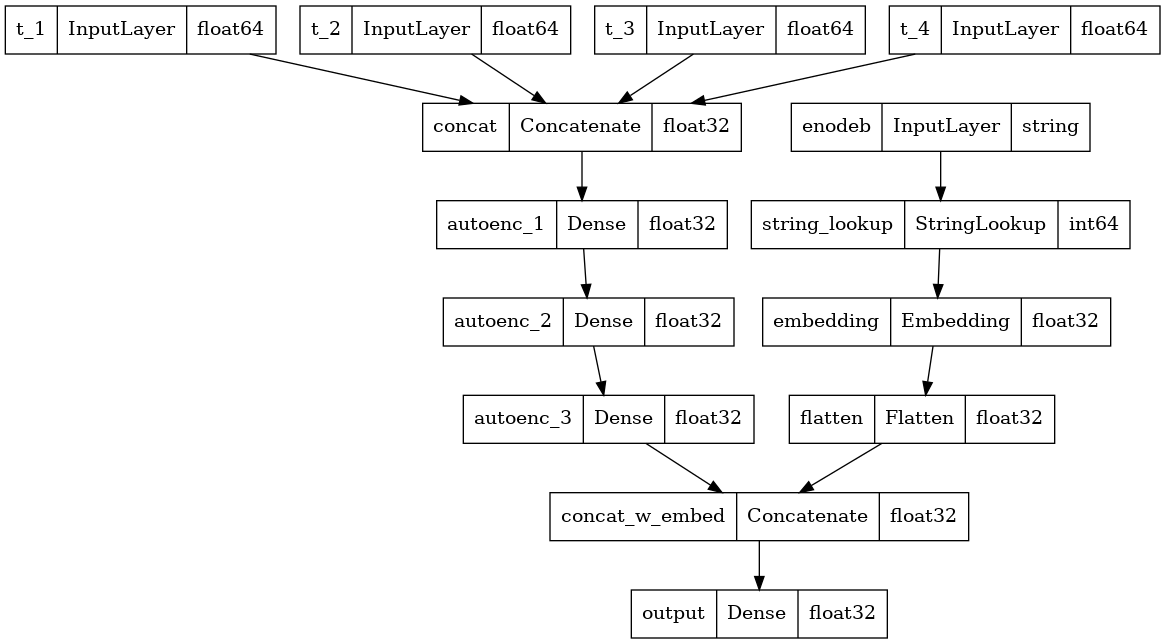

In [15]:
tf.keras.utils.plot_model(autoencoder, show_dtype=True)

In [16]:
batch_size=5

In [17]:
history = autoencoder.fit(training_ds,
                        epochs=3,
                        # validation_data=(test_array, test_array), 
                        batch_size=batch_size) #,
                        #shuffle=True,
                        #callbacks=[reduce_lr, model_checkpoint_callback])

Epoch 1/3


2022-06-17 19:40:04.518528: E tensorflow/core/framework/dataset.cc:580] UNIMPLEMENTED: Cannot compute input sources for dataset of type IO>BigQueryDataset, because the dataset does not implement `InputDatasets`.
2022-06-17 19:40:04.518593: E tensorflow/core/framework/dataset.cc:584] UNIMPLEMENTED: Cannot merge options for dataset of type IO>BigQueryDataset, because the dataset does not implement `InputDatasets`.


20/20 [==============================] - 2s 30ms/step - loss: 9.8909e-05 - mae: 0.0034
Epoch 2/3
20/20 [==============================] - 0s 4ms/step - loss: 1.0951e-06 - mae: 8.8705e-04


2022-06-17 19:40:05.438723: E tensorflow/core/framework/dataset.cc:580] UNIMPLEMENTED: Cannot compute input sources for dataset of type IO>BigQueryDataset, because the dataset does not implement `InputDatasets`.
2022-06-17 19:40:05.438783: E tensorflow/core/framework/dataset.cc:584] UNIMPLEMENTED: Cannot merge options for dataset of type IO>BigQueryDataset, because the dataset does not implement `InputDatasets`.


Epoch 3/3
14/20 [====================>.........] - ETA: 0s - loss: 1.1962e-06 - mae: 9.1505e-04

2022-06-17 19:40:05.757454: E tensorflow/core/framework/dataset.cc:580] UNIMPLEMENTED: Cannot compute input sources for dataset of type IO>BigQueryDataset, because the dataset does not implement `InputDatasets`.
2022-06-17 19:40:05.757547: E tensorflow/core/framework/dataset.cc:584] UNIMPLEMENTED: Cannot merge options for dataset of type IO>BigQueryDataset, because the dataset does not implement `InputDatasets`.


20/20 [==============================] - 0s 10ms/step - loss: 1.0951e-06 - mae: 8.8705e-04
